이번 과제는 Bert Model을 사용하여 BBC 뉴스 기사의 category를 분류해보는 과제입니다. clone coding을 하시되, 코드 주석을 line by line으로 꼼꼼하게 달아보시며 공부해보세요!

## 데이터 로드 및 탐색

In [1]:
%%capture
!pip install transformers

In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/24-summer KUBIG NLP/WEEK4/bbc-text.csv')

In [5]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [6]:
print(len(df))

2225


In [8]:
df.groupby('category').count() # 카테고리 별 분류

,text
category,
business,510
entertainment,386
politics,417
sport,511
tech,401


### Bert 모델
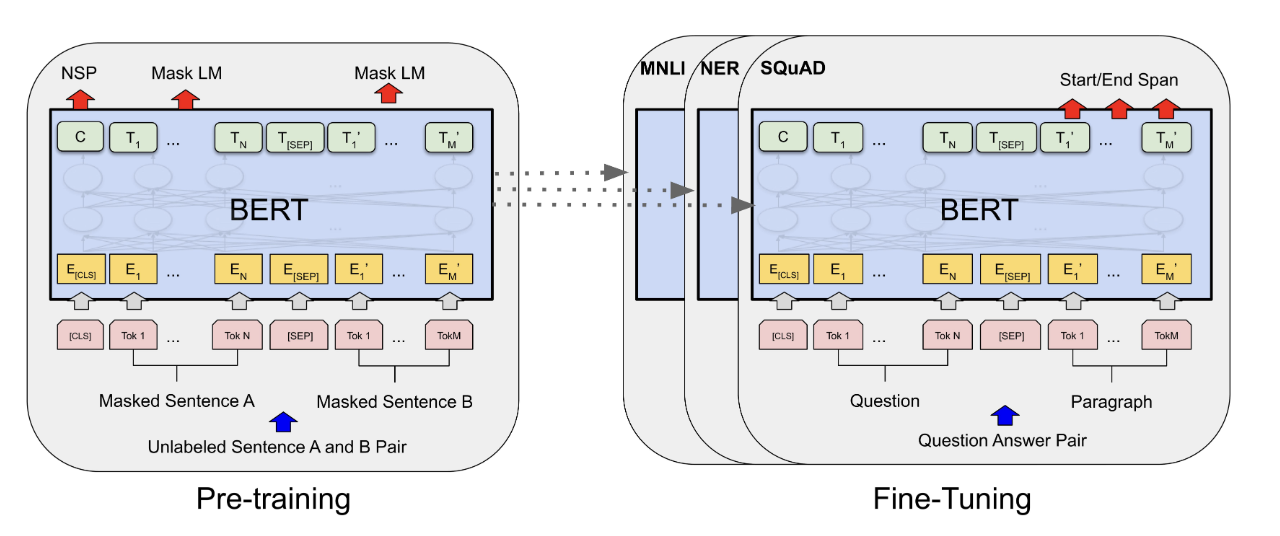


Transformer 아키텍처를 기반으로 하고 양방향(bidirectional) 학습을 사용

## BertTokenizer

토크나이저로 pretrain된 BERT의 BertTokenizer를 갖고 옵니다. 여러 종류를 시도해보세요.

- bert-base-uncased : 108MB param, all lowercase
- bert-large-cased : 340MB param, both upper and lower
- bert-base-cased : 108MB param, multi language, both upper and lower


In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased') # 다국어 지원, 대소문자 혼용 가능
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

## Dataset

In [13]:
class Dataset(torch.utils.data.Dataset): # 데이터 셋 클래스 정의

    def __init__(self, df):
        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

## Train & Evaluate BertClassifier

pretrain된 BertModel을 불러옵니다. 다른 간단한 층들도 같이 쌓아줍니다.

- bert-base-cased: 12-layer, 768-hidden, 12-self attention heads, 110M parameters. Trained on cased English text.


다른 종류들의 pretrianed model은 아래 링크에서 확인할 수 있습니다.

https://huggingface.co/transformers/v2.9.1/pretrained_models.html

In [14]:
class BertClassifier(nn.Module): # 초기화, 순전파 과정

    def __init__(self, dropout=0.5): # 초기화, 사전학습 모델 불러오기

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')  # 레이어 및 활성화 함수 정의
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask): # 순전파 메서드

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [22]:
# 마스크 텐서 차원 조절 수정 3d->2d

def train(model, train_data, val_data, learning_rate, epochs): # 학습

    train, val = Dataset(train_data), Dataset(val_data) # 초기화

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True) # 데이터 로더 생성
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss() # 손실함수 및 옵티마이저
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs): # 에폭 성정

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                mask = mask.squeeze(1)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad() # 파라미터 업데이트 전 그래디언트 초기화
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad(): # 평가모드

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    # Ensure the mask is 2D
                    mask = mask.squeeze(1)  # Remove an extra dimension if present

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')

In [26]:
# 마스크 텐서 차원 조절 수정 3d->2d

def evaluate(model, test_data): # 평가

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda: # 가능하다면 gpu 사용

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad(): # 평가모드 전환

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              mask = mask.squeeze(1)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [20]:
np.random.seed(112) # 데이터 셋 분할
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [24]:
EPOCHS = 4 #EPOCH 수 늘려보기!
model = BertClassifier()
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 890/890 [03:11<00:00,  4.64it/s]


Epochs: 1 | Train Loss:  0.684 | Train Accuracy:  0.435 | Val Loss:  0.585 | Val Accuracy:  0.559


100%|██████████| 890/890 [03:12<00:00,  4.63it/s]


Epochs: 2 | Train Loss:  0.463 | Train Accuracy:  0.720 | Val Loss:  0.305 | Val Accuracy:  0.887


100%|██████████| 890/890 [03:12<00:00,  4.62it/s]


Epochs: 3 | Train Loss:  0.217 | Train Accuracy:  0.947 | Val Loss:  0.152 | Val Accuracy:  0.959


100%|██████████| 890/890 [03:12<00:00,  4.63it/s]


Epochs: 4 | Train Loss:  0.110 | Train Accuracy:  0.978 | Val Loss:  0.087 | Val Accuracy:  0.977


In [27]:
evaluate(model, df_test)

Test Accuracy:  0.978
